### Task 10: Add Constant Product Trading interest rate as continuous rebase
* https://cryptorating.eu/whitepapers/Aave/aave-v2-whitepaper.pdf

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.event.state.series import StateSeries
from python.dev.event.state import State
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.token.trade import Convert
from python.dev.cpt import Liquidity
from python.dev.cpt import PriceCurve
from python.dev.cpt import ConstantProductTrade
from python.dev.plot import PlotPriceCurve
from python.dev.token import AToken

In [2]:
time0 = time.time()

In [3]:
APY = 0.1
rec = State(Deposit(0,0,0))
rec.init_first_state(time0)
state_series = StateSeries()

for k in range(320):
    delta = np.random.gamma(1, 10)   
    select = np.random.choice(2, 1, p=[0.70, 0.30])[0]
    t_delta = np.random.negative_binomial(1, 0.00001)
      
    if(select == 0): 
        event = Deposit(APY,delta,t_delta)
    else:
        event = Withdraw(APY,delta,t_delta)  

    rec.update_event(event)
    state_series.add_state(rec)
    
    #print('{} {}'.format(rec.get_principle(),rec.get_balance() )) 

principle = state_series.get_principle() 
balance = state_series.get_balance() 
tSamp = state_series.get_tstamp()

In [4]:
for k in range(10):
    type_event = state_series.get_state(k).get_event().type_of()
    print('{}: {} @ {}'.format(k, type_event, tSamp[k]))

0: DEPOSIT @ 2022-04-20 11:25:15.305583
1: DEPOSIT @ 2022-04-21 05:16:58.305583
2: WITHDRAW @ 2022-04-21 12:25:04.305583
3: DEPOSIT @ 2022-04-22 02:39:47.305583
4: WITHDRAW @ 2022-04-25 02:42:02.305583
5: DEPOSIT @ 2022-04-25 10:09:57.305583
6: DEPOSIT @ 2022-04-26 18:08:52.305583
7: DEPOSIT @ 2022-04-27 06:25:34.305583
8: DEPOSIT @ 2022-04-28 08:41:27.305583
9: WITHDRAW @ 2022-05-01 13:42:15.305583


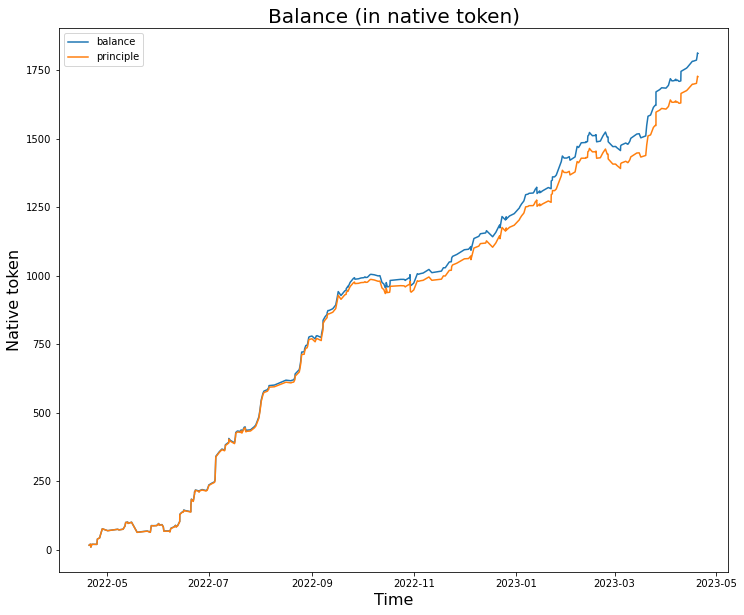

In [5]:
import matplotlib.pyplot as plt

fig, (balance_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 10))

balance_ax.plot(tSamp, balance, label='balance') 
balance_ax.plot(tSamp, principle, label='principle') 

balance_ax.set_title("Balance (in native token)", fontsize=20)
balance_ax.set_ylabel("Native token", fontsize=16)
balance_ax.set_xlabel('Time', fontsize=16)
balance_ax.legend()


[Initial] T1: 3672.01 TDT: 2673.30
[Trade 0] T1: 3672.01121 TDT: 2673.30167 L: 3133.11246
[Trade 0] T1_prin: 3672.01121 T1_balance: 3672.01121
[Trade 0] TDT_prin: 2673.30167 TDT_balance: 2673.30167

[Trade 50] T1: 2830.12209 TDT: 3626.06342 L: 3200.79360
[Trade 50] T1_prin: 2773.46841 T1_balance: 2830.12209
[Trade 50] TDT_prin: 3571.84447 TDT_balance: 3626.06342

[Trade 100] T1: 3802.72938 TDT: 2761.55706 L: 3304.36024
[Trade 100] T1_prin: 3692.79216 T1_balance: 3802.72938
[Trade 100] TDT_prin: 2652.52072 TDT_balance: 2761.55706

[Trade 150] T1: 3546.09504 TDT: 3113.27331 L: 3434.50214
[Trade 150] T1_prin: 3384.22597 T1_balance: 3546.09504
[Trade 150] TDT_prin: 2961.08690 TDT_balance: 3113.27331

[Trade 200] T1: 5081.53282 TDT: 1670.33242 L: 3631.13205
[Trade 200] T1_prin: 4859.37075 T1_balance: 5081.53282
[Trade 200] TDT_prin: 1485.94213 TDT_balance: 1670.33242



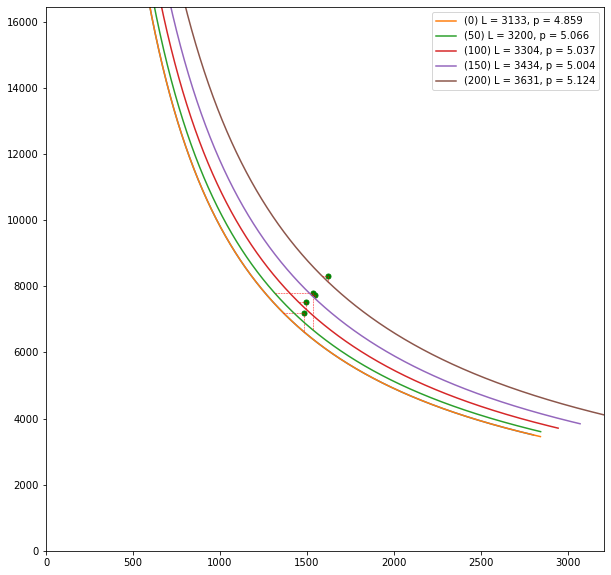

In [8]:
percent = 0.05
N = 250

# Initialize Test Tokens

TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
TYPE_DEBT_TOKEN = 'DEBT'

t_delta = np.random.negative_binomial(1, 0.00001)
depositT1 = np.random.gamma(2, 2000, 1)[0]

T1 = AToken(TYPE_DEPOSIT_TOKEN)
t1Address = T1.gen_address()
T1.init_token(time0, t1Address)
T1.add_event(Deposit(APY, depositT1, t_delta, t1Address))

t_delta = np.random.negative_binomial(1, 0.00001)
depositTDT = np.random.gamma(2, 2000, 1)[0]

TDT = AToken(TYPE_DEBT_TOKEN)
tdtAddress = TDT.gen_address()
TDT.init_token(time0, tdtAddress)
TDT.add_event(Deposit(APY, depositTDT, t_delta, tdtAddress))

x = T1.get_balance_deposits()
y = TDT.get_balance_deposits()

print('[Initial] T1: {:.2f} TDT: {:.2f}'.format(x,y))

# Initialize Liquidity Pool
liq = Liquidity(x,y)
L = liq.calc(); p = np.random.normal(5,0.1,1)[0]
cpt = ConstantProductTrade(L)
pCurve = PriceCurve(L)
plotCurve = PlotPriceCurve(L, cpt, pCurve)
plotCurve.apply(p, None)


for k in range(N):
    # Generate random delta denomenated in Native token, 
    # rebalance respective accounts and convert to T1
    delta_x = cpt.random_delta(500)
    t_delta = np.random.negative_binomial(1, 0.00001)

    select = np.random.choice(2, 1, p=[0.50, 0.50])[0]
    if(select == 0): 
        T1.add_event(Withdraw(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Deposit(APY, delta_x, t_delta, tdtAddress))               
    else:            
        T1.add_event(Deposit(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Withdraw(APY, delta_x, t_delta, tdtAddress))         
    
    TDT_yield = TDT.get_state_series(tdtAddress).get_state(k).get_yield()
    T1_yield = T1.get_state_series(t1Address).get_state(k).get_yield()
    
    liq.add_y(TDT_yield)
    liq.add_x(T1_yield) 
    
    L = liq.update(delta_x); p = np.random.normal(5,0.1,1)[0]
    if (k % int(N/(100*percent)) == 0):
        plotCurve.apply_next(p, L, '({}) L = {}, p = {:.3f}'.format(k, int(L),p))
        plotCurve.plot_trade(p, delta_x, 'r--')
        T1_prin = T1.get_state_series(t1Address).get_state(k).get_principle()
        T1_balance = T1.get_state_series(t1Address).get_state(k).get_balance()

        TDT_prin = TDT.get_state_series(tdtAddress).get_state(k).get_principle()
        TDT_balance = TDT.get_state_series(tdtAddress).get_state(k).get_balance()
            
        print('[Trade {}] T1: {:.5f} TDT: {:.5f} L: {:.5f}'.format(k, x,y,L))
        print('[Trade {}] T1_prin: {:.5f} T1_balance: {:.5f}'.format(k, T1_prin,T1_balance))
        print('[Trade {}] TDT_prin: {:.5f} TDT_balance: {:.5f}\n'.format(k, TDT_prin,TDT_balance))
      
    x = T1.get_balance_deposits()
    y = TDT.get_balance_deposits()



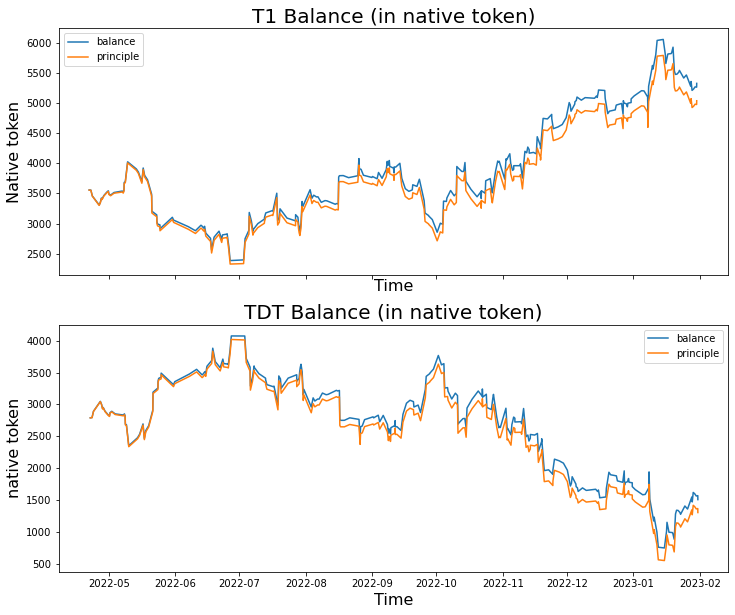

In [9]:
T1_states = T1.get_state_series(t1Address)
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, TDT_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (in native token)", fontsize=20)
T1_ax.set_ylabel("Native token", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TDT_states = TDT.get_state_series(tdtAddress)
principle = TDT_states.get_principle() 
balance = TDT_states.get_balance() 
tSamp = TDT_states.get_tstamp() 

TDT_ax.plot(tSamp[1:], balance[1:], label='balance') 
TDT_ax.plot(tSamp[1:], principle[1:], label='principle') 
TDT_ax.set_title("TDT Balance (in native token)", fontsize=20)
TDT_ax.set_ylabel("native token", fontsize=16)
TDT_ax.set_xlabel('Time', fontsize=16)
TDT_ax.legend()